#  Fit GLM to all IBL data together

In [4]:
"""
IMPORTS
"""
import autograd.numpy as np
import autograd.numpy.random as npr
import os
from glm_utils import load_session_fold_lookup, load_data, fit_glm, \
    plot_input_vectors, append_zeros
    
from preprocessing_utils import get_animal_name, load_animal_list, load_animal_eid_dict, \
get_all_unnormalized_data_this_session, create_train_test_sessions

In [5]:
"""
PARAMETERS
"""
C = 2  # number of output types/categories
N_initializations = 1
npr.seed(65)  # set seed in case of randomization
num_folds = 5
bin_num = 10


In [8]:
"""
DIRECTORIES
"""
data_dir = '../../data/ibl/data_for_cluster/'
data_dir = '/home/ines/repositories/representation_learning_variability/DATA/GLMHMM/'
#data_dir = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/GLMHMM/'

"""
Create folders to save processed data
"""
# Create directories for saving data:
processed_ibl_data_path = data_dir + "data_for_cluster/" + "data_by_animal/"

# Create directory for results:
results_dir = '../../../results/proficient/ibl_global_fit/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

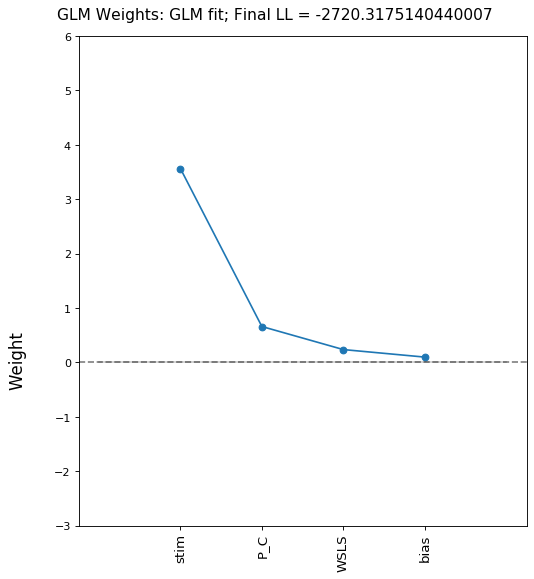

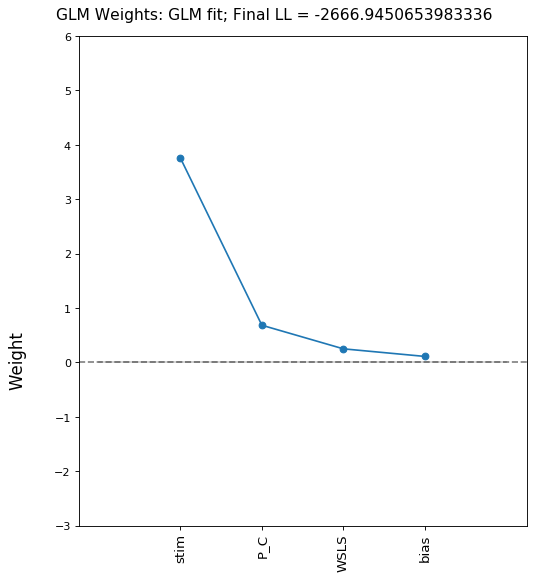

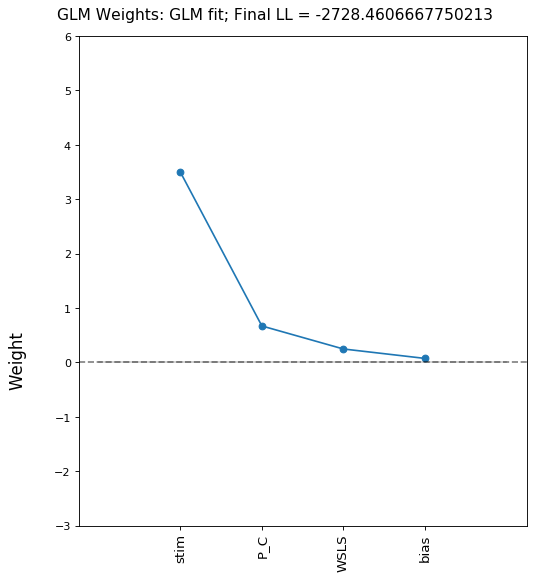

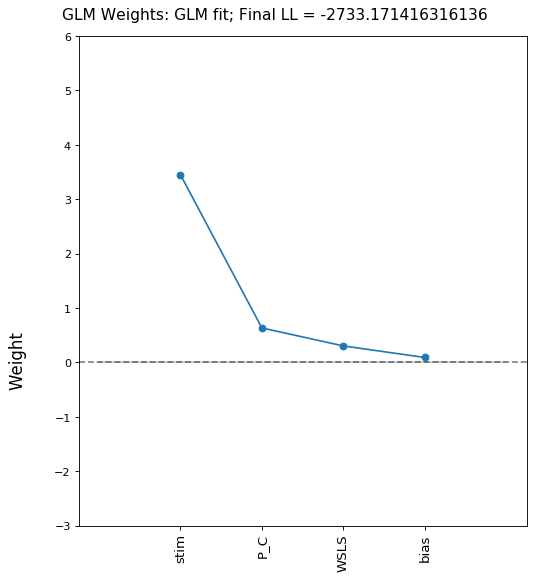

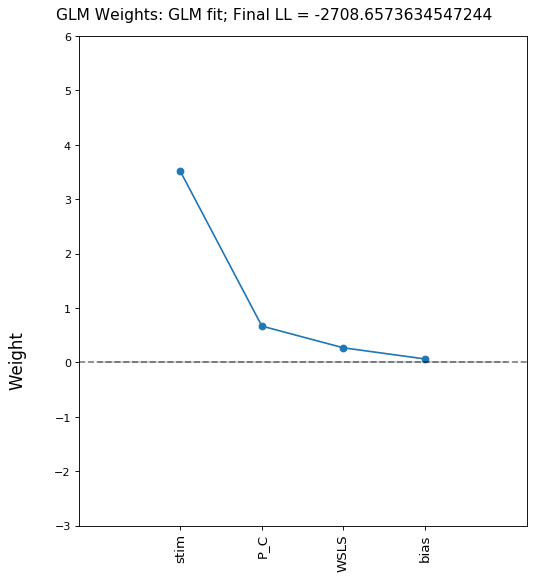

In [20]:
# Fit GLM to all data
animal_file = data_dir + "data_for_cluster/" + 'all_animals_concat.npz'
inpt, y, bin_data = load_data(animal_file)
session_fold_lookup_table = load_session_fold_lookup(
    data_dir + "data_for_cluster/" + 'all_animals_concat_session_fold_lookup.npz')

for fold in range(num_folds):
    # Subset to relevant covariates for covar set of interest:
    labels_for_plot = ['stim', 'P_C', 'WSLS', 'bias']
    y = y.astype('int')
    figure_directory = results_dir + "GLM/fold_" + str(fold) + '/'
    if not os.path.exists(figure_directory):
        os.makedirs(figure_directory)

    # Subset to trials of interest for fold

    trials_idx = np.arange(len(y))
    keep_fold = trials_idx[
        np.where(session_fold_lookup_table[:, 1] != fold)]  # TODO: what is y == -1?


    keep_y = [y[id, 0] != -1
        for id, binn in enumerate(trials_idx)]
    keep_y = trials_idx[keep_y]
    idx_to_keep = np.sort(np.intersect1d(keep_y, keep_fold))
    idx_this_fold = trials_idx[idx_to_keep]
    
    this_inpt, this_y, this_session = inpt[idx_this_fold, :], \
                                        y[idx_this_fold, :], \
                                        bin_data[idx_this_fold]    
 
    
    assert len(
        np.unique(this_y)
    ) == 2, "choice vector should only include 2 possible values"
    train_size = this_inpt.shape[0]

    M = this_inpt.shape[1]
    loglikelihood_train_vector = []

    for iter in range(N_initializations):  # GLM fitting should be
        # independent of initialization, so fitting multiple
        # initializations is a good way to check that everything is
        # working correctly
        loglikelihood_train, recovered_weights = fit_glm([this_inpt],
                                                            [this_y], M, C)
        weights_for_plotting = append_zeros(recovered_weights)
        plot_input_vectors(weights_for_plotting,
                            figure_directory,
                            title="GLM fit; Final LL = " +
                            str(loglikelihood_train),
                            save_title='init' + str(iter),
                            labels_for_plot=labels_for_plot)
        loglikelihood_train_vector.append(loglikelihood_train)
        np.savez(
            figure_directory + 'variables_of_interest_iter_' + str(iter) +
            '.npz', loglikelihood_train, recovered_weights)
